# Regular LSTM with PyTorch

Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from src.models.lstm_vanilla import LSTMVanilla
from src.models.lstm_optimized import LSTMVanillaOptimized
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
device = torch.device("cuda" if not torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Device name: {torch.cuda.get_device_name(0)}")

Using device: cpu
Device name: NVIDIA GeForce RTX 4050 Laptop GPU


Import dataset

In [3]:
data = pd.read_csv('../data/raw/daily-minimum-temperatures-in-me.csv')
data.rename(columns={'Date': 'date', 'Daily minimum temperatures in Melbourne, Australia, 1981-1990': 'min_temp'}, inplace=True)
data

,date,min_temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
...,...,...
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7


Preprocess data

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      3650 non-null   object
 1   min_temp  3650 non-null   object
dtypes: object(2)
memory usage: 57.2+ KB


In [5]:
data.dropna(inplace=True)
data.isnull().sum()

date        0
min_temp    0
dtype: int64

Get non-numeric characters

In [6]:
data['min_temp'] = data['min_temp'].apply(lambda x: x.replace('?', '-'))

Convert date and string columns to numeric values

In [7]:
data['date'] = pd.to_datetime(data['date'])
data['min_temp'] = pd.to_numeric(data['min_temp'])

View Dataset

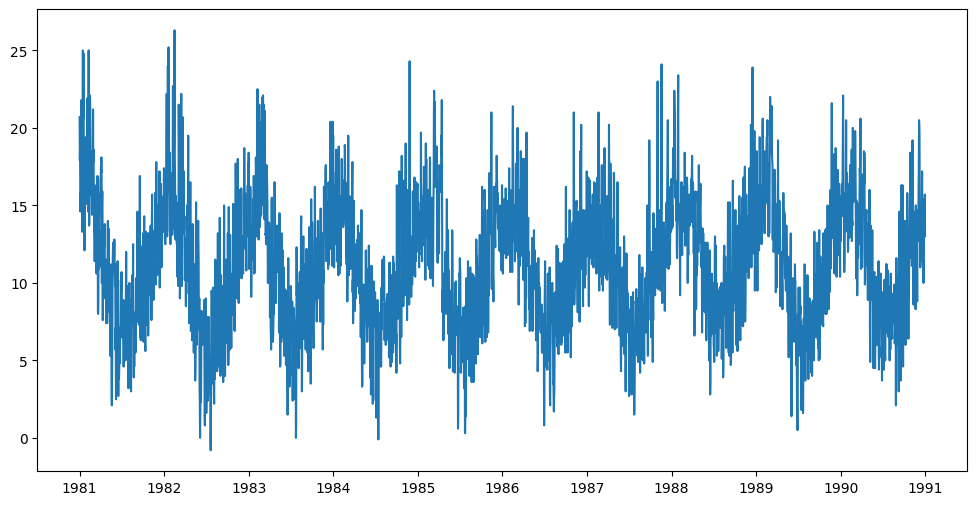

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['min_temp'])
plt.show()

Generate the sequence from the dataset

In [9]:
time_series = data['min_temp'].values

sequence_length = 15
X = []
y = []
for i in range(len(time_series) - sequence_length):
    # The input sequence is the slice from i to i + sequence_length
    sequence = time_series[i : i + sequence_length]
    X.append(sequence)

    # The target is the single value immediately after the sequence
    target = time_series[i + sequence_length]
    y.append(target)

# Convert the lists to NumPy arrays for use in ML models
X = np.array(X)
y = np.array(y)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

Normalize the data

In [10]:
scaler_x = StandardScaler()
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1,1))
y_test = scaler_y.transform(y_test.reshape(-1,1))

Transform numpy array to tensor

In [11]:
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()

X_train = X_train.unsqueeze(2)
X_test = X_test.unsqueeze(2)

print("--- Tensors After Reshaping (Ready for LSTM) ---")
print("X_train final shape:", X_train.shape)
print("y_train final shape:", y_train.shape)
print("X_test final shape:", X_test.shape)
print("y_test final shape:", y_test.shape)

--- Tensors After Reshaping (Ready for LSTM) ---
X_train final shape: torch.Size([2908, 15, 1])
y_train final shape: torch.Size([2908, 1])
X_test final shape: torch.Size([727, 15, 1])
y_test final shape: torch.Size([727, 1])


Create a Data Loader

In [14]:
BATCH_SIZE = 32

# Create TensorDatasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Train regular LSTM

In [15]:
model = LSTMVanillaOptimized(input_size=X_train.shape[2], hidden_size=16, output_size=1)
model.to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 300

start_event = torch.cuda.Event(enable_timing=True)
end_event = torch.cuda.Event(enable_timing=True)
start_event.record()

for epoch in range(epochs):

    model.train()

    train_loss = 0
    count = 0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = model(X_batch)

        loss = loss_function(y_pred, y_batch)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(X_batch)
            test_loss += loss_function(y_pred, y_batch).item()
            
    avg_test_loss = test_loss / len(test_loader)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch: {epoch + 1}, Test Loss: {avg_test_loss:.4f}, Train Loss: {avg_train_loss:.4f}')

end_event.record()
torch.cuda.synchronize()

elapsed_time_ms = start_event.elapsed_time(end_event)
elapsed_time_sec = elapsed_time_ms / 1000
minutes = int(elapsed_time_sec // 60)
seconds = int(elapsed_time_sec % 60)

print(f"\nTraining finished in {minutes} minutes and {seconds} seconds.")

Epoch: 10, Test Loss: 0.3013, Train Loss: 0.3746
Epoch: 20, Test Loss: 0.2936, Train Loss: 0.3675
Epoch: 30, Test Loss: 0.3010, Train Loss: 0.3658
Epoch: 40, Test Loss: 0.2908, Train Loss: 0.3648
Epoch: 50, Test Loss: 0.2905, Train Loss: 0.3633
Epoch: 60, Test Loss: 0.2892, Train Loss: 0.3615
Epoch: 70, Test Loss: 0.2888, Train Loss: 0.3618
Epoch: 80, Test Loss: 0.2885, Train Loss: 0.3618
Epoch: 90, Test Loss: 0.2876, Train Loss: 0.3602
Epoch: 100, Test Loss: 0.2875, Train Loss: 0.3590
Epoch: 110, Test Loss: 0.2867, Train Loss: 0.3569
Epoch: 120, Test Loss: 0.2856, Train Loss: 0.3573
Epoch: 130, Test Loss: 0.2852, Train Loss: 0.3556
Epoch: 140, Test Loss: 0.2870, Train Loss: 0.3547
Epoch: 150, Test Loss: 0.2916, Train Loss: 0.3537
Epoch: 160, Test Loss: 0.2864, Train Loss: 0.3527
Epoch: 170, Test Loss: 0.2865, Train Loss: 0.3508
Epoch: 180, Test Loss: 0.2876, Train Loss: 0.3497
Epoch: 190, Test Loss: 0.2885, Train Loss: 0.3478
Epoch: 200, Test Loss: 0.2886, Train Loss: 0.3473
Epoch: 21

Visualize the Model

In [ ]:
from torchviz import make_dot
model_plot = LSTMVanilla(input_size=1, hidden_size=20, output_size=1)
y_hat = model(torch.randn(1, 1, 1))
make_dot(y_hat, params=dict(model_plot.named_parameters())).render("atached", format="png")

RuntimeError: Expected all tensors to be on the same device, but got mat2 is on cuda:0, different from other tensors on cpu (when checking argument in method wrapper_CUDA_mm)

In [ ]:
# import torch.onnx
# model = LSTM(input_size=1, hidden_size=20, output_size=1)
# model.eval()
# dummy_input = torch.randn(1, 5, 1)
# onnx_file_path = "lstm_model.onnx"
# torch.onnx.export(
#     model,                  # The model to export
#     dummy_input,            # A sample input to trace the model
#     onnx_file_path,         # Where to save the model
#     input_names=['input'],  # Names for the graph's input nodes
#     output_names=['output'], # Names for the graph's output nodes
#     dynamic_axes={          # Makes the model flexible
#         'input': {0: 'batch_size', 1: 'sequence_length'},
#         'output': {0: 'batch_size', 1: 'sequence_length'}
#     },
#     opset_version=11        # A widely compatible ONNX version
# )
# print(f"Model successfully exported to {onnx_file_path}")

Plot the results of the LSTM model

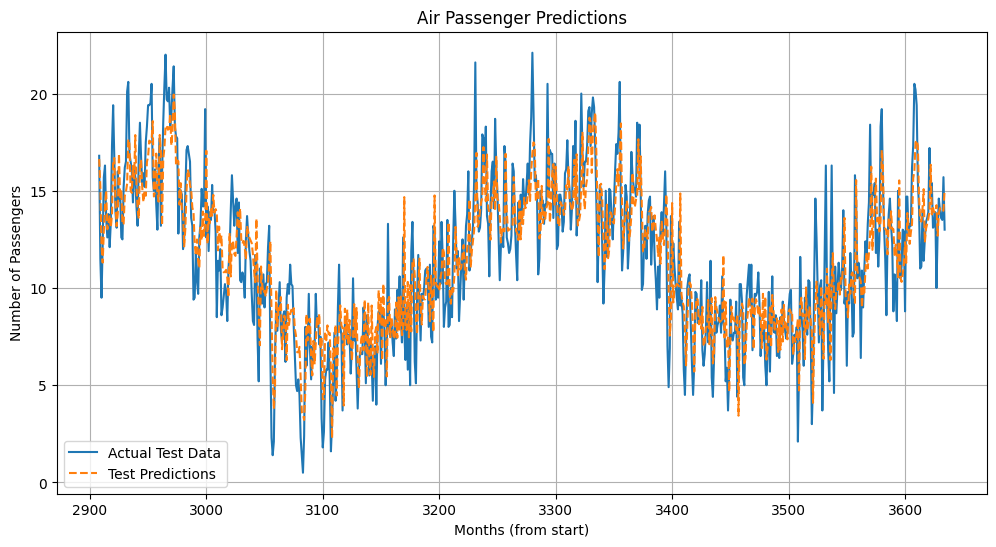

In [17]:
# Ensure the model is in evaluation mode
model.eval()

# --- 1. Get Predictions ---
with torch.no_grad():
    train_plot = model(X_train.to(device))
    test_plot = model(X_test.to(device))

# --- 2. Inverse Transform Data for Plotting ---
# Move tensors to CPU and convert to NumPy arrays
train_predictions = scaler_y.inverse_transform(train_plot.to('cpu').numpy())
train_actuals = scaler_y.inverse_transform(y_train.to('cpu').numpy())
test_predictions = scaler_y.inverse_transform(test_plot.to('cpu').numpy())
test_actuals = scaler_y.inverse_transform(y_test.to('cpu').numpy())

# --- 3. Create the Plot ---
plt.figure(figsize=(12, 6))

# Plot the original passenger data (actuals)
# We plot both train and test actuals together to get a continuous line
# plt.plot(scaler_y.inverse_transform(y_train.numpy()), label='Actual Train Data')
plt.plot(range(len(train_actuals), len(train_actuals) + len(test_actuals)), test_actuals, label='Actual Test Data')

# Plot the training predictions
# This will start from index 0 and go up to the end of the training set
# plt.plot(train_predictions, label='Train Predictions', linestyle='--')

# Plot the test predictions
# This needs a new x-axis range that starts after the training data
test_x_axis = range(len(train_predictions), len(train_predictions) + len(test_predictions))
plt.plot(test_x_axis, test_predictions, label='Test Predictions', linestyle='--')


plt.title('Air Passenger Predictions')
plt.xlabel('Months (from start)')
plt.ylabel('Number of Passengers')
plt.legend()
plt.grid(True)
plt.show()